# 02. Neural Network Classification with PyTorch

## 1. Make Classification data and get it ready

In [7]:
import sklearn
from sklearn.datasets import make_circles

In [8]:
# Make a 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

In [9]:
len(X), len(y)

(1000, 1000)

In [10]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [11]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1],
                        "label": y})

In [12]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


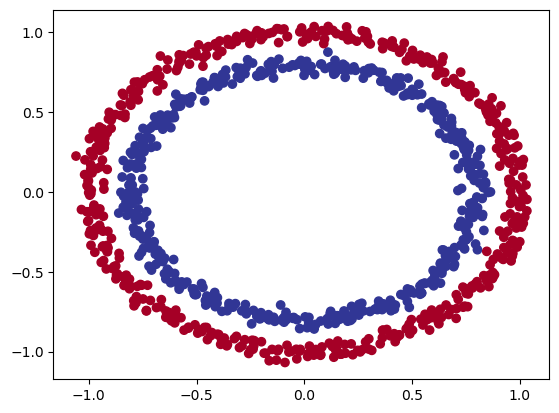

In [13]:
# Visualize data

import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

 ### 1.1 Check input and output shapes

In [15]:
X.shape, y.shape

((1000, 2), (1000,))

In [16]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [17]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

X_sample, y_sample

(array([0.75424625, 0.23148074]), 1)

### 1.2 Turn data into tensors and create train and test split

In [19]:
import torch
torch.__version__

'2.3.1'

In [20]:
type(X)

numpy.ndarray

In [21]:
# Turn data into tensors

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [22]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test and 80% train
                                                    random_state=42)

In [23]:
len(X_train), len(X_test)

(800, 200)

## 2. Building a model

build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Defining a loss function and optimizer
4. Create a training and test loop

In [25]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'mps' if torch.backends.mps.is_available() else "cpu"
device

'mps'

### 2.2
Lets create a model that:
1. Subclasses `nn.Module` (almost all models in PyTorch subclass)
2. Creates 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model
4. Instantiate an instance of our model class and send it to the target device

In [27]:
# 1. Create a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    # 3. Define a forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 (output layer)

# 4. Instantiate an instance of the class and send to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [28]:
next(model_0.parameters())

Parameter containing:
tensor([[-0.5918, -0.4407],
        [ 0.6730,  0.0362],
        [ 0.2123,  0.5494],
        [-0.0342, -0.5184],
        [-0.2433, -0.5494]], device='mps:0', requires_grad=True)

In [29]:
# Lets replicate the model above using nn.Sequential()

model_0 = nn.Sequential( 
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [30]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1353, -0.1147],
                      [-0.3378,  0.5951],
                      [ 0.1183, -0.3040],
                      [ 0.3407,  0.2488],
                      [-0.3257,  0.4572]], device='mps:0')),
             ('0.bias',
              tensor([ 0.6417,  0.5921, -0.6729, -0.0469, -0.6673], device='mps:0')),
             ('1.weight',
              tensor([[-0.4210,  0.3931,  0.2850,  0.1358, -0.3475]], device='mps:0')),
             ('1.bias', tensor([0.2273], device='mps:0'))])

In [31]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"First 10 predictions:\n {untrained_preds[:10]}")
print(f"First 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])
First 10 predictions:
 tensor([[0.2705],
        [0.2914],
        [0.1991],
        [0.2908],
        [0.1727],
        [0.1856],
        [0.2654],
        [0.2406],
        [0.2003],
        [0.2925]], device='mps:0')
First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [33]:
# Setup the loss function
# loss_fun = nn.BCELoss() requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [34]:
# Calculate accuracy - out of 100 examples what percentage does our model get right
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

 ## 3. Train Model

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Model outputs are going to be raw **logits**
Convert the **logits** into **prediction probabilities** by passing them some kind of activation function (e.g. sigmoid or softmax).

Then convert **prediction probabilities** into **prediction labels** by rounding or taking the ``argmax()``

In [37]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[0.2705],
        [0.2914],
        [0.1991],
        [0.2908],
        [0.1727]], device='mps:0')

In [38]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [39]:
# Use the sigmoid activation function on our model logits to turn them to prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5672],
        [0.5723],
        [0.5496],
        [0.5722],
        [0.5431]], device='mps:0')

In [40]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0')

### 3.2 Building a training and testing loop

In [42]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backward (backpropagation)
    loss.backward()

    #5. Optimizer step (gradient descent)
    optimizer.step()


    ### Testing
    model_0.eval()
    with torch.inference_mode():
        #1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calc loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69919, Acc: 50.00% | Test loss: 0.70041, Test acc: 50.00%
Epoch: 10 | Loss: 0.69416, Acc: 50.00% | Test loss: 0.69580, Test acc: 50.00%
Epoch: 20 | Loss: 0.69321, Acc: 56.00% | Test loss: 0.69485, Test acc: 52.00%
Epoch: 30 | Loss: 0.69303, Acc: 51.88% | Test loss: 0.69464, Test acc: 49.00%
Epoch: 40 | Loss: 0.69300, Acc: 51.38% | Test loss: 0.69458, Test acc: 46.50%
Epoch: 50 | Loss: 0.69299, Acc: 51.50% | Test loss: 0.69457, Test acc: 46.50%
Epoch: 60 | Loss: 0.69299, Acc: 51.38% | Test loss: 0.69456, Test acc: 47.50%
Epoch: 70 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69456, Test acc: 47.50%
Epoch: 80 | Loss: 0.69298, Acc: 51.38% | Test loss: 0.69456, Test acc: 47.00%
Epoch: 90 | Loss: 0.69298, Acc: 51.25% | Test loss: 0.69456, Test acc: 47.00%
Epoch: 100 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69457, Test acc: 47.00%
Epoch: 110 | Loss: 0.69298, Acc: 51.38% | Test loss: 0.69457, Test acc: 46.50%
Epoch: 120 | Loss: 0.69298, Acc: 50.88% | Test loss: 0.69458, T

## 4. Make predictions and evaluate the model

From the metrics it looks like our model is not learning correctly 

So to inspect it lets make some predictions and visualize them

In [44]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("file already exists")
else:
    print("Downloading the file")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

file already exists


In [45]:
from helper_functions import plot_predictions, plot_decision_boundary

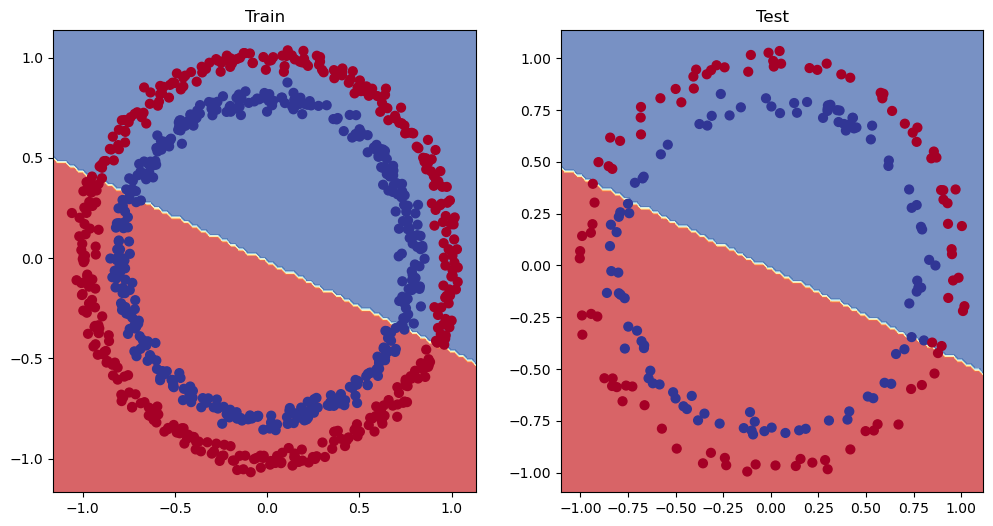

In [46]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from the model's perspective because they deal with the model rather than the data going into the model.

Lets try and improve our model by:
* adding more hidden units 5 -> 10
* increase the number of layers 2 -> 3
* increase the number of epochs 100 -> 1000

In [48]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features = 10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [49]:
# Loss fn
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [50]:
### Train and Testing Loop
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        

    

Epoch: 0 | Loss: 0.69396, Acc: 51.00% | Test loss: 0.69261, Test acc: 46.00%
Epoch: 100 | Loss: 0.69305, Acc: 51.00% | Test loss: 0.69379, Test acc: 46.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.00% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69458, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


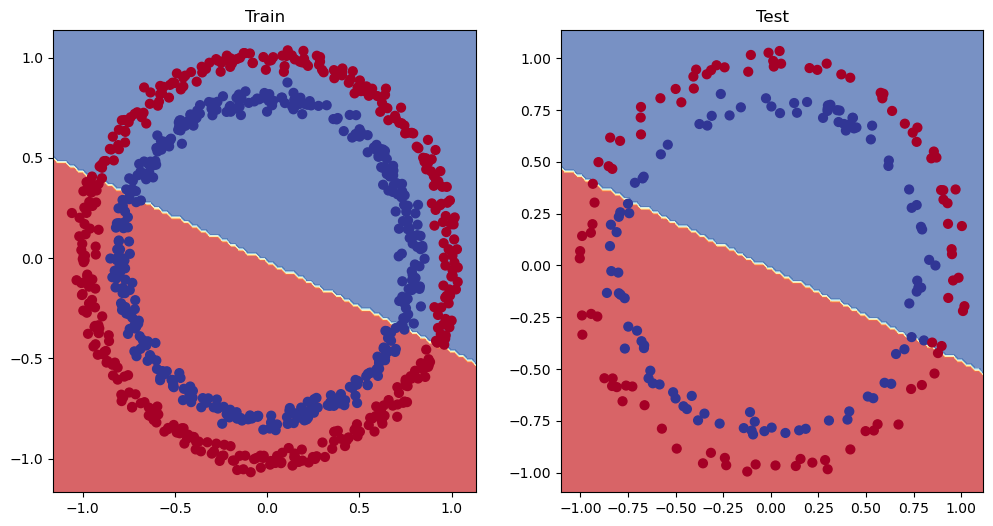

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The missing piece of our model: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

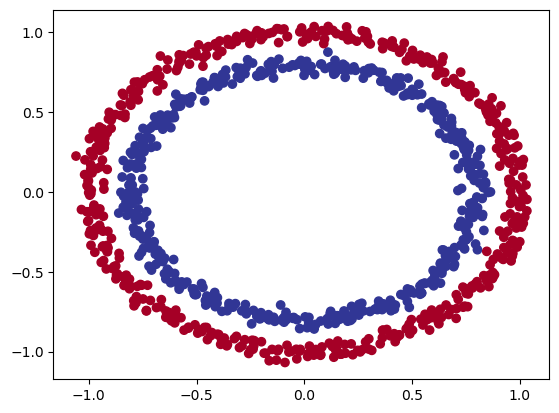

In [54]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

n_samples = 1000


X, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [55]:
# Convert data to tensors and then to train and test split
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity



In [57]:
# Build a model with non-linear activation functions

from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__() 
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [58]:
## Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [60]:
# Random seeds

torch.manual_seed(42)
torch.mps.manual_seed(42)

# Put all data on target device
model_3.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 2000

for epoch in range(epochs):
    ### Training
    
    # 1. Forward pass
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test acc: 79.00%
Epoch: 1000 | Loss: 0.56818, Acc: 87.75% | Test loss: 0.57378, Test acc: 86.50%
Epoch: 1100 | Loss: 0.48153, Acc: 93.50% | Test loss: 0.49935, Test acc: 90.50%
Epoch: 1200 | Loss: 0.37056, Acc: 97.75% | Test loss

 ### 6.4 Evaluating a model trained with non-linear activation functions

In [62]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'))

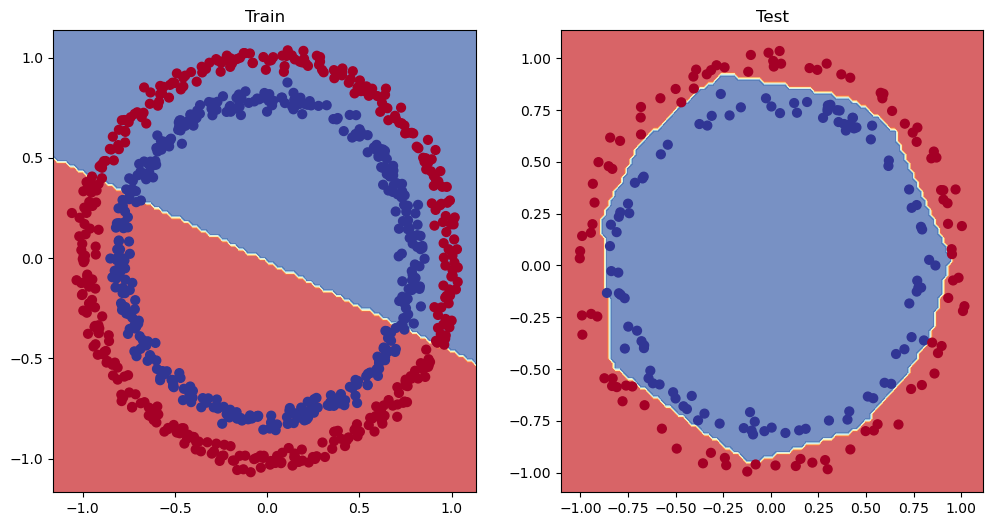

In [63]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replication non-linear activation functions

In [65]:
# Create a tensor
A = torch.arange(-10, 10, 1.,)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

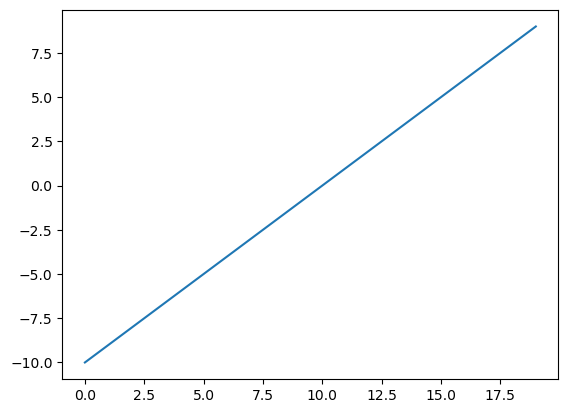

In [66]:
# Visualize the tensor
plt.plot(A)

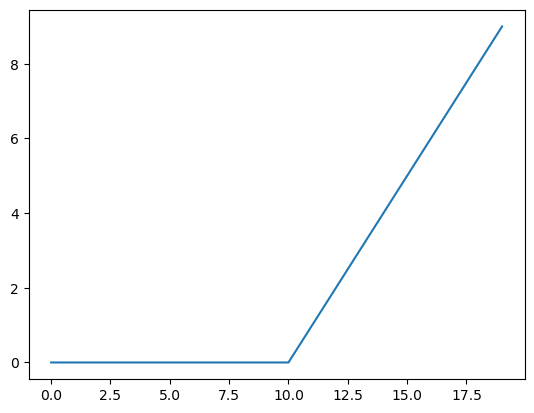

In [67]:
plt.plot(torch.relu(A))

In [68]:
def relu(x: torch.Tensor)-> torch.Tensor:
    return torch.max(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

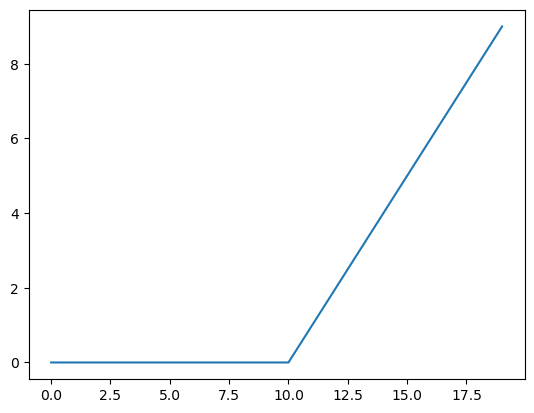

In [69]:
# Plot ReLU activation function
plt.plot(relu(A))

## 8. Putting it all together with a multi-class classification problem

In [54]:
# Import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_functions import accuracy_fn, plot_decision_boundary

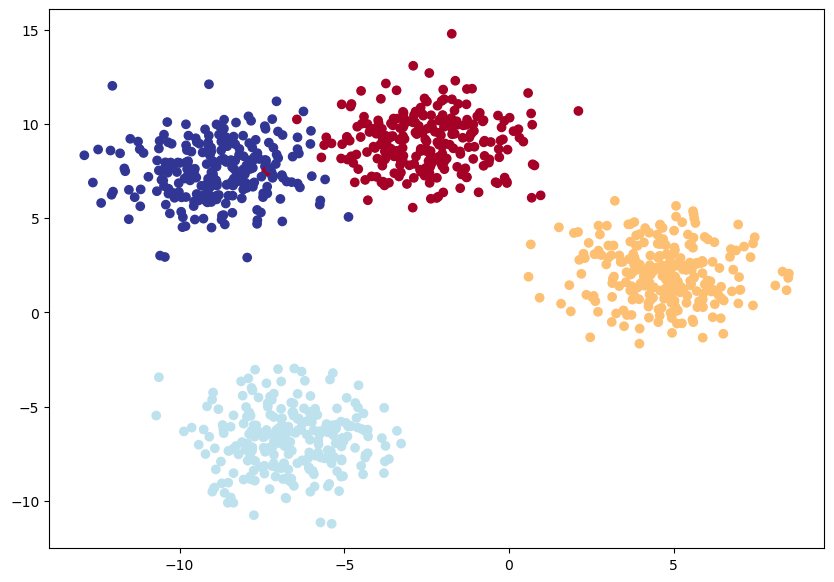

In [34]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features = NUM_FEATURES, 
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# 3. Train and Test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2, random_state=RANDOM_SEED)

#4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu) 

                                                                        

### 8.2 Building a multi-class classification model in PyTorch

In [37]:
 # Create device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [39]:
# Build a multiclass classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance and send to target device
model_4 = BlobModel(input_features=2, output_features=4).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [41]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

### 8.3 Create a loss function and an optimizer for a mutli-class classification model

In [44]:
# Create loss function
loss_fn = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(), 
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

Convert our models outputs (logits) to prediction probabilities and then to prediction labels

Logits  (raw output of model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the `argmax` of the prediction probabilities)

### 8.5 Create a training and testing loop for a multi-class PyTorch model

In [52]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.02657, Acc: 99.25% | Test loss: 0.01651, Test acc: 99.50%
Epoch: 10 | Loss: 0.02634, Acc: 99.25% | Test loss: 0.01621, Test acc: 99.50%
Epoch: 20 | Loss: 0.02613, Acc: 99.25% | Test loss: 0.01593, Test acc: 99.50%
Epoch: 30 | Loss: 0.02595, Acc: 99.25% | Test loss: 0.01568, Test acc: 99.50%
Epoch: 40 | Loss: 0.02578, Acc: 99.25% | Test loss: 0.01545, Test acc: 99.50%
Epoch: 50 | Loss: 0.02563, Acc: 99.25% | Test loss: 0.01524, Test acc: 99.50%
Epoch: 60 | Loss: 0.02549, Acc: 99.25% | Test loss: 0.01504, Test acc: 99.50%
Epoch: 70 | Loss: 0.02536, Acc: 99.25% | Test loss: 0.01486, Test acc: 99.50%
Epoch: 80 | Loss: 0.02524, Acc: 99.25% | Test loss: 0.01470, Test acc: 99.50%
Epoch: 90 | Loss: 0.02513, Acc: 99.25% | Test loss: 0.01454, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [61]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -1.0652,   8.2798,  -9.1449, -10.2100],
        [ -2.4755,  -7.7620,  -4.9026,   4.3642],
        [ -4.5196,  -4.9315,   4.3766,  -3.4838],
        [ -1.7697,   5.9513,  -4.7679,  -5.8968],
        [  5.3451,  -1.6304, -10.8774,  -8.3668],
        [ -3.1530,  -9.2199,  -5.7116,   5.2368],
        [ -3.9928,  -4.2288,   3.8460,  -2.8900],
        [  4.7623,  -5.1601,  -8.3182,  -4.2139],
        [ -5.7480,  -6.2989,   5.3565,  -4.4740],
        [  4.9971,  -3.8428,  -9.0331,  -5.6022]], device='mps:0')

In [74]:
# Go from logits -> prediction probs

y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[8.7394e-05, 9.9991e-01, 2.7072e-08, 9.3314e-09],
        [1.0692e-03, 5.4098e-06, 9.4405e-05, 9.9883e-01],
        [1.3682e-04, 9.0627e-05, 9.9939e-01, 3.8548e-04],
        [4.4323e-04, 9.9953e-01, 2.2106e-05, 7.1491e-06],
        [9.9907e-01, 9.3358e-04, 9.0001e-08, 1.1081e-06],
        [2.2711e-04, 5.2655e-07, 1.7583e-05, 9.9975e-01],
        [3.9339e-04, 3.1070e-04, 9.9811e-01, 1.1852e-03],
        [9.9982e-01, 4.9052e-05, 2.0851e-06, 1.2636e-04],
        [1.5044e-05, 8.6715e-06, 9.9992e-01, 5.3784e-05],
        [9.9983e-01, 1.4482e-04, 8.0669e-07, 2.4929e-05]], device='mps:0')

In [65]:
# Go from pred probs -> pred labels

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')

In [67]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')

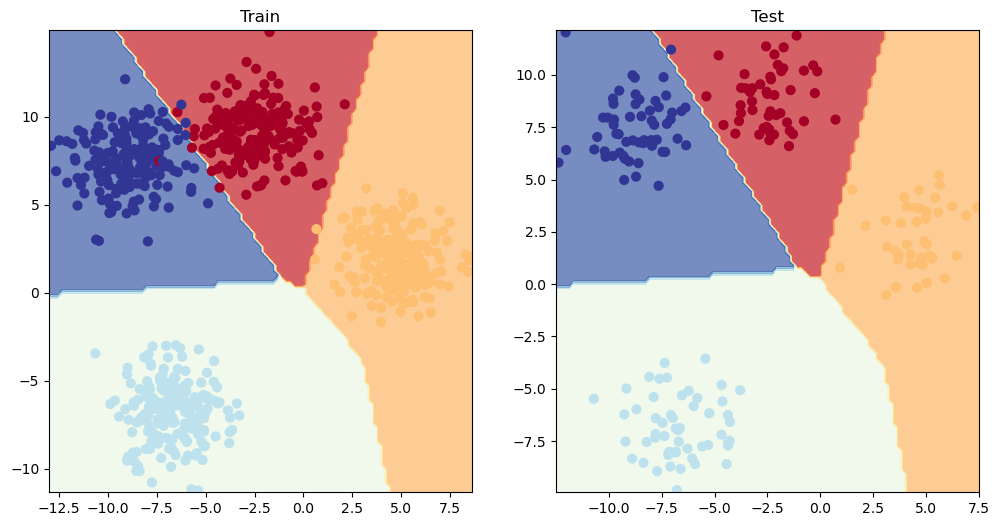

In [76]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics
* Accuracy
* Precision
* Recall
* F1-score
* Confusion Matrix
* Classification report

Article for accuracy vs precision vs recall:
https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

In [84]:
import torchmetrics
from torchmetrics import Accuracy

In [88]:
# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='mps:0')